In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from pathlib import Path
from numpy import pi as PI

In [2]:
def display_image(arr, title, cmap='gray'):
    '''
    displays the image using matplotlib

    Args:
        arr (numpy array): image
        title (str): title of the image
        cmap (str): image colormap

    Returns:
        (None)
    
    '''
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()

### Convolution

* It flips the kernel first, since we are performing the convolution operation.
* It adds padding to the image so that the resulting output size does not change.
* Then the kernel is placed over the starting point of image. Here a summation of element wise multiplication is performed.
* The computations are performed as the kernel is slid over the image.

In [3]:
def convolution(ip, kernel):
    '''
    applies the kernel on the image

    Args:
        ip (numpy array): input image
        ipShape (tuple): input array shape
        kernel (numpy array): image filter

    Returns:
        opImg (numpy array): output image

    '''
    kernel = np.flip(kernel)
    
    # add padding to the input images to preserve size
    sidePadding = (kernel.shape[0] - 1) // 2
    padding = (sidePadding, sidePadding)
    paddedIp = np.pad(ip, (padding, padding), 'constant')
    
    # convolves the kernel with the image
    op = np.empty(ip.shape)
    for x in range(ip.shape[0]):
        for y in range(ip.shape[1]):
            dx = x + kernel.shape[0]
            dy = y + kernel.shape[1]
            op[x, y] = np.sum(paddedIp[x:dx, y:dy] * kernel)
              
    return op

### Gaussian Smoothing

* Generates the 2D gaussian kernel given the kernel size and the sigma values.
* The generated gaussian kernel is convolved with the input image.
* Gaussian kernel basically smoothens the image and reduces the noise in the image (as seen in Machine Problem 1).
* The effect of different parameters is explained later, but generally we expect more smoothing/blurring as the sigma value is increased.
* Gaussian kernels have peak value in the center and diminish as we go towards the edges and corners. These values also sum to one.

In [4]:
def gaussianSmoothing(ip, size, sigma):
    '''
    smoothens the input image

    Args:
        ip (numpy array): input image
        size (int): kernel size
        sigma (int): sigma value to generate the gaussian kernel

    Returns:
        (numpy array): smoothed image
        
    '''
    s = 2 * sigma**2
    denom = 1 / (np.pi * s)
    kernel = np.full((size, size), denom)

    x, y = np.mgrid[-(size//2): size//2+1, -(size//2): size//2+1]
    kernel *= np.exp(-(x**2 + y**2) / s)
    kernel /= np.abs(kernel).sum()
    Smoothed = convolution(ip, kernel)

    display_image(Smoothed, title='Smoothed Image')
    
    return Smoothed

### Image Gradient

* Generates the sobel operator and calculates the horizontal as well as vertical gradient of the image.
* Gradient is calculated by convolving the sobel operator with the image.
* Then the image magnitude is calculated as the square root of the sum of squares of the horizontal and vertical gradient.
* Also, the angle is calculated in radians using tan inverse of the gradients.
* The angle shows the direction of the increase in image gradient.

In [5]:
def imageGradient(ip):
    '''
    calculates the image magnitude and theta

    Args:
        ip (numpy array): input image

    Returns:
        magnitude (numpy array): image magnitude
        theta (numpy array): image theta angle
    
    '''
    sobel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    
    hor_grad = convolution(ip, sobel)
    ver_grad = convolution(ip, sobel.T)

    magnitude = np.sqrt(np.square(hor_grad) + np.square(ver_grad))
    magnitude *= 255 / magnitude.max()
    theta = np.arctan2(ver_grad, hor_grad)
    
    display_image(magnitude, title='Magnitude')
    display_image(theta, title='Theta', cmap='viridis')

    return magnitude, theta

### Suppressing Non-maxima

* Finds the local maxima in the image.
* Then it suppresses the neighboring non-maxima values in the direction of the gradient angle (theta).
* This helps in thinning the wide edges to edges that are single pixel thick.
* Here the edges can be thought of as ridges and the sides of this ridge are suppressed.

In [6]:
def nonMaximaSuppress(mag, theta):
    '''
    suppresses the non-maximum values in the image using the theta angle calculated

    Args:
        mag (numpy array): image magnitude
        theta (numpy array): image theta angle

    Returns:
        suppressedMag (numpy array): suppressed image
        
    '''
    suppressedMag = np.zeros(mag.shape)
    h, w = theta.shape[0], theta.shape[1]
    
    # checks non-maxima values for each pixel
    for x in range(h):
        for y in range(w):
            angle = theta[x, y]
            
            # finds the neighboring pixels depending on the theta angle
            if (PI/8 < angle <= 3*PI/8) or (-5*PI/8 <= angle < -7*PI/8):
                # for the upper-right and lower-left neighbors
                firstNeigh = mag[x+1, y-1] if (x < h-1 and y > 0) else 0
                secondNeigh = mag[x-1, y+1] if (x > 0 and y < w-1) else 0
                
            elif (3*PI/8 < angle <= 5*PI/8) or (-3*PI/8 <= angle < -5*PI/8):
                # for the top and bottom neighbors
                firstNeigh = mag[x-1, y] if (x > 0) else 0
                secondNeigh = mag[x+1, y] if (x < h-1) else 0
                
            elif (5*PI/8 < angle <= 7*PI/8) or (-PI/8 <= angle < -3*PI/8):
                # for the upper-left and lower-right neighbors
                firstNeigh = mag[x-1, y-1] if (x > 0 and y > 0) else 0
                secondNeigh = mag[x+1, y+1] if (x < h-1 and y < w-1) else 0
                
            else:
                # for the left and right neighbors
                firstNeigh = mag[x, y-1] if (y > 0) else 0
                secondNeigh = mag[x, y+1] if (y < w-1) else 0
                
            # checks if neighbors are non-maxima and suppresses them accordingly
            if mag[x, y] >= firstNeigh and mag[x, y] >= secondNeigh:
                suppressedMag[x, y] = mag[x, y]
                
    display_image(suppressedMag, title='Suppressed Magnitude')
                
    return suppressedMag

### Hysteresis Thresholding

* The edges obtained in the previous operations are divided into three categories.
* These edges are classified as either noise (hence removed), weak edge (changed to an intermediate value between 0 and 255), or a strong edge (changed to 255).
* These classifications are performed based on the thresholds decided beforehand.
* Generally, higher the thresholds, more noise will be removed, but more information will also be lost in the edges.
* This technique helps in removing noise while preserving the intermediate values (as weak edges).

In [7]:
def hysteresisThreshold(mag, low, high, weak, strong):
    '''
    applies Hysteresis thresholding on the image by classifying values as weak or strong

    Args:
        mag (numpy array): image magnitude
        low (int): the low threshold for the image
        high (int): the high threshold for the image
        weak (int): pixel value for values between low and high threshold
        strong (int): pixel value for the values above high threshold

    Returns:
        op (numpy array): image after thersholding
    
    '''
    op = np.zeros(mag.shape)
    op[(mag >= low) & (mag <= high)] = weak
    op[mag > high] = strong
    
    display_image(op, title='Hysteresis Thresholding')
    
    return op

### Edge Linking

* Now that we have obtained the strong as well as the weak edges, we can start converting the required weak edges to strong edges in the process called as edge linking.
* This process works as follows:
    1. Find a pixel in the image belonging to a strong edge.
    2. Recursively convert the neighboring pixels that belong to a weak edge into a strong pixel value.
    3. Repeat the process for each pixel belonging to a strong edge.
* The helper method `convertNeighbors` is used to perform DFS (Depth First Search) and recursively perform edge linking on the neighboring weak edges.

In [8]:
def edgeLinking(mag):
    '''
    converts the weak edges that are connected to strong edges to strong edges

    Args:
        mag (numpy array): image magnitude

    Returns:
        mag (numpy array): processed image
    
    '''
    for x in range(1, mag.shape[0]-1):
        for y in range(1, mag.shape[1]-1):
            if mag[x, y] == 255:
                convertNeighbors(mag, x, y)
            
    mag[mag != 255] = 0
    
    display_image(mag, title='Edge Linking')
    
    return mag

In [9]:
def convertNeighbors(arr, x, y):
    '''
    applies DFS (Depth First Search) algorithm to convert weak neighbors of strong edges to strong edges

    Args:
        arr (numpy array): input image
        x (int): image x coordinate
        y (int): image y coordinate

    Returns:
        (None)
    
    '''
    for rShift, cShift in moves:
        if 0 < arr[x+rShift, y+cShift] < 255:
            arr[x+rShift, y+cShift] = 255
            convertNeighbors(arr, x+rShift, y+cShift)

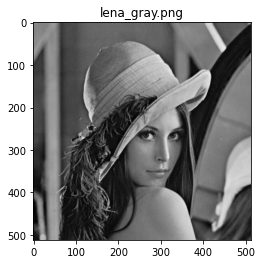

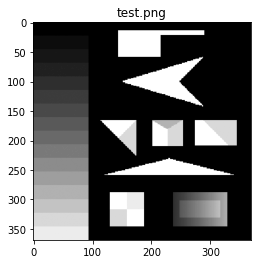

In [10]:
# used by convertNeighbors to recursively find weak neighbors
moves = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1), (-1, 1), (1, -1)]

# add paths to the input images
path = Path.cwd() / 'res'
inputRes = path / 'input'
lenaPath = str(inputRes / 'lena_gray.png')
testPath = str(inputRes / 'test.png')

# read images
lenaImg = cv.imread(lenaPath, -1)
lenaSize = lenaImg.shape
testImg = cv.imread(testPath, -1)
testSize = testImg.shape

# check whether images are read correctly
display_image(lenaImg, title='lena_gray.png')
display_image(testImg, title='test.png')

---

# First program run
## Image used: lena_gray.png
### Gaussian smoothing parameters:
```
kernel size = 3
sigma = 1
```

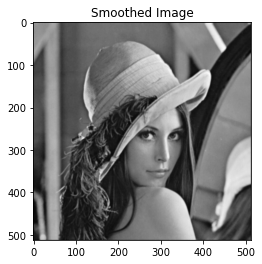

In [11]:
# 1. Gaussian Smoothing
S = gaussianSmoothing(ip=lenaImg, size=3, sigma=1)

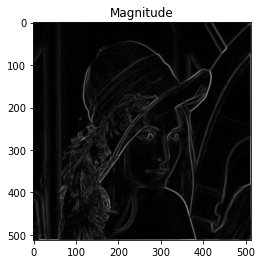

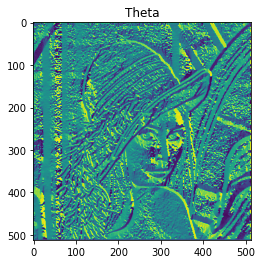

In [12]:
# 2. Calculating image gradient
mag, theta = imageGradient(S)

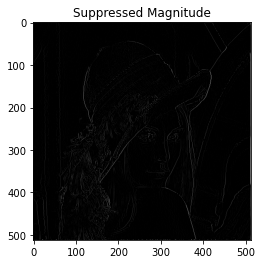

In [13]:
# 3. Suppressing Nonmaxima
suppressedMag = nonMaximaSuppress(mag, theta)

### Thresholding parameters 1:
```
low threshold = 10
high threshold = 20
noise value = 0
weak edge value = 128
strong edge value = 255
```

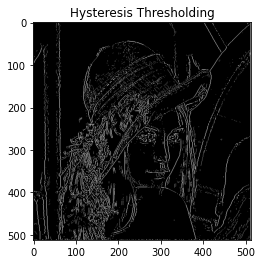

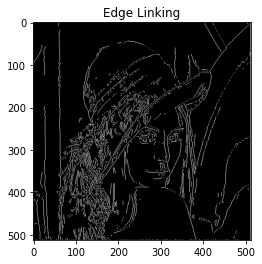

In [14]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=10, high=20, weak=128, strong=255)
E = edgeLinking(thresholdMag)

### Thresholding parameters 2:
```
low threshold = 15
high threshold = 30
noise value = 0
weak edge value = 128
strong edge value = 255
```

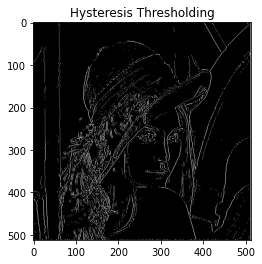

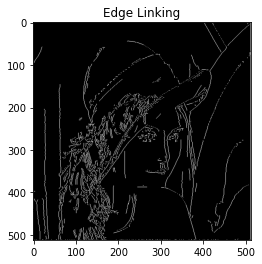

In [15]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=15, high=30, weak=128, strong=255)
E = edgeLinking(thresholdMag)

---

# Second program run
## Image used: lena_gray.png
### Gaussian smoothing parameters:
```
kernel size = 5
sigma = 5
```

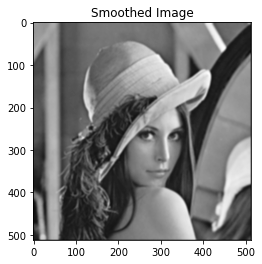

In [16]:
# 1. Gaussian Smoothing
S = gaussianSmoothing(ip=lenaImg, size=5, sigma=5)

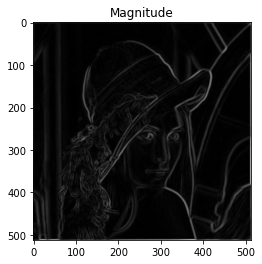

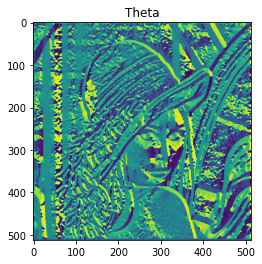

In [17]:
# 2. Calculating image gradient
mag, theta = imageGradient(S)

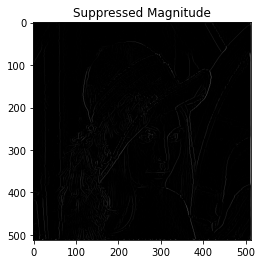

In [18]:
# 3. Suppressing Nonmaxima
suppressedMag = nonMaximaSuppress(mag, theta)

### Thresholding parameters 1:
```
low threshold = 10
high threshold = 20
noise value = 0
weak edge value = 128
strong edge value = 255
```

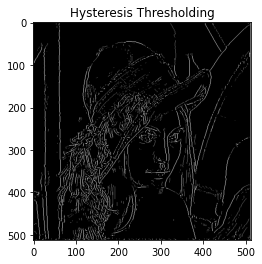

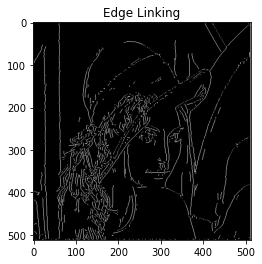

In [19]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=10, high=20, weak=128, strong=255)
E = edgeLinking(thresholdMag)

### Thresholding parameters 2:
```
low threshold = 15
high threshold = 30
noise value = 0
weak edge value = 128
strong edge value = 255
```

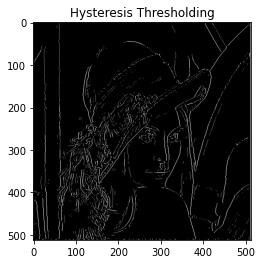

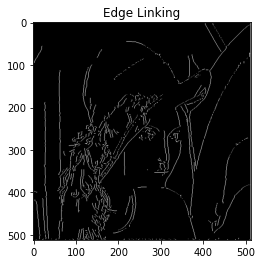

In [20]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=15, high=30, weak=128, strong=255)
E = edgeLinking(thresholdMag)

---

# Third program run
## Image used: test.png
### Gaussian smoothing parameters:
```
kernel size = 3
sigma = 1
```

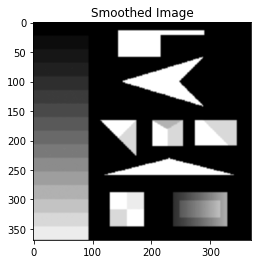

In [21]:
# 1. Gaussian Smoothing
S = gaussianSmoothing(ip=testImg, size=3, sigma=1)

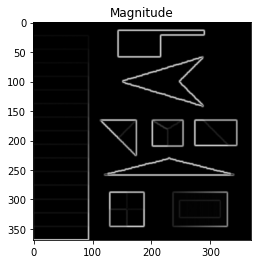

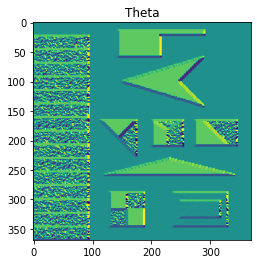

In [22]:
# 2. Calculating image gradient
mag, theta = imageGradient(S)

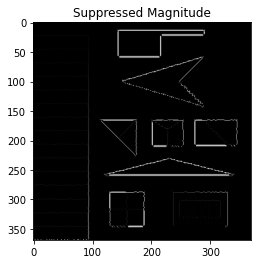

In [23]:
# 3. Suppressing Nonmaxima
suppressedMag = nonMaximaSuppress(mag, theta)

### Thresholding parameters 1:
```
low threshold = 5
high threshold = 10
noise value = 0
weak edge value = 128
strong edge value = 255
```

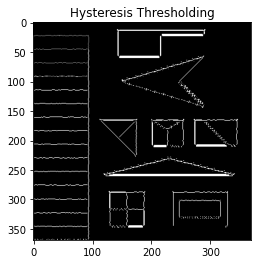

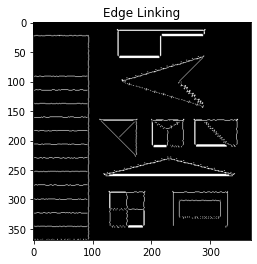

In [24]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=5, high=10, weak=128, strong=255)
E = edgeLinking(thresholdMag)

### Thresholding parameters 2:
```
low threshold = 10
high threshold = 20
noise value = 0
weak edge value = 128
strong edge value = 255
```

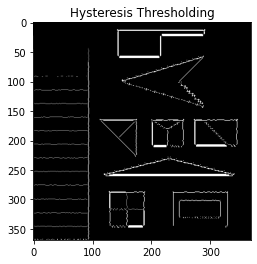

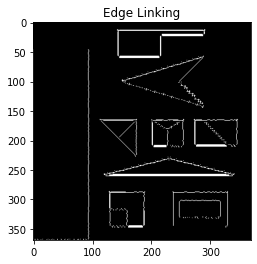

In [25]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=10, high=20, weak=128, strong=255)
E = edgeLinking(thresholdMag)

---

# Fourth program run
## Image used: test.png
### Gaussian smoothing parameters:
```
kernel size = 5
sigma = 5
```

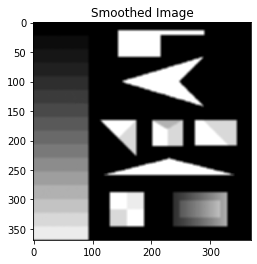

In [26]:
# 1. Gaussian Smoothing
S = gaussianSmoothing(ip=testImg, size=5, sigma=5)

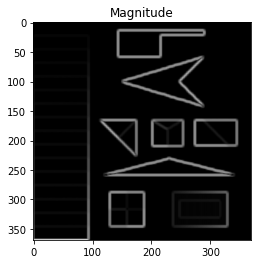

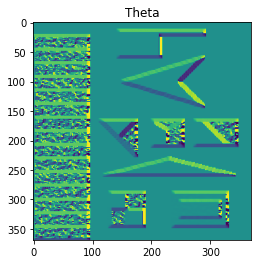

In [27]:
# 2. Calculating image gradient
mag, theta = imageGradient(S)

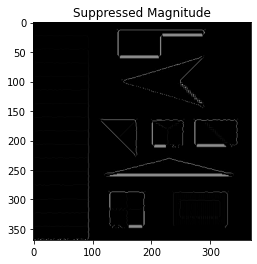

In [28]:
# 3. Suppressing Nonmaxima
suppressedMag = nonMaximaSuppress(mag, theta)

### Thresholding parameters 1:
```
low threshold = 5
high threshold = 10
noise value = 0
weak edge value = 128
strong edge value = 255
```

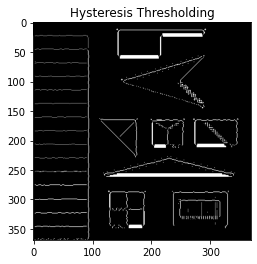

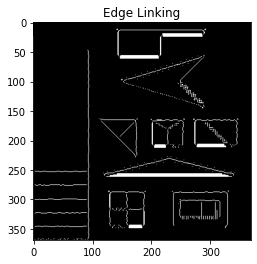

In [29]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=5, high=10, weak=128, strong=255)
E = edgeLinking(thresholdMag)

### Thresholding parameters 2:
```
low threshold = 10
high threshold = 20
noise value = 0
weak edge value = 128
strong edge value = 255
```

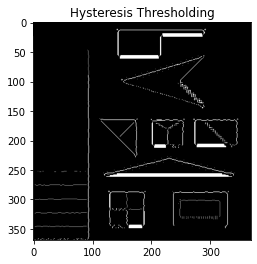

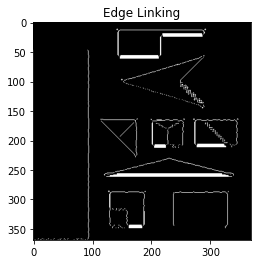

In [30]:
# 4. Thresholding and Edge Linking
thresholdMag = hysteresisThreshold(mag=suppressedMag, low=10, high=20, weak=128, strong=255)
E = edgeLinking(thresholdMag)

---

# Result Analysis

## Gaussian Smoothing
* The the kernel sizes tried are 3 and 5. Kernel size 5 and sigma 5 produces a smoother image than kernel size 3 and sigma 1.
* In gaussian smoothing, different sigma values make more impact on the results. So, the tests have been run on sigma values of 1 and 5 for both the images.
* As can be seen, for `sigma = 1` we have lesser smoothing. Hence, the resulting images not only have more detail but also have some unwanted noise.
* Some of the edges in the hat of the **lena.png** image is connected for **sigma = 1** but they seem disconnected for the higher sigma value. So, we lost some edge information when the sigma was increased.
* But, this is not necessarily bad as lower noise is also observed in the results where higher sigma was chosen.
* The same effect can be observed in the **test.png** image, higher sigma led to loss of some detailed edges but noise was also reduced.

## Image Gradients
* We can see that the magnitude is high where there is rapid change in the intensity of the image.
* This information is helpful for detecting the edges in the image.
* Also, the magnitude is effectively telling us the direction of the gradient. This will help is suppressing the non-maxima values.

## Suppressing Non-maxima
* A single edge is being represented by a thick line in the previous result.
* After non-maxima suppression we have effectively remove this redundancy, and replaced the thick edges with with single pixel width edges. 
* Hence, here the resulting edges are extremely thin and get rid of excess information.

## Hysteresis Thresholding
* Even after getting these edges, we can observe some noise in the results. Hysteresis thresholding is the perfect way to get rid of it.
* The experiments have been run on different thresholds to classiy data into noise, weak edges, and strong edges.
* For the **lena_gray.png** image thresholds of 10 and 20 effectively removed the noise that gaussian smoothing could not remove.
* But when these thresholds were increased to 15 and 30, we can observe some loss of edge information. So it is better to not keep the thresholds too high.
* This does not mean every image can use the same threshold values. For the **test.png** image the thresholds had to be further reduced to get some edges which it would otherwise classify as noise when **lena_test.png** thresholds were used.
* For example, in the **test.png** image, the combination of small sigma (for gaussian kernel) and lower thresholds lead to better retention of edge information than larger sigma and higher thresholds.
* But for **lena_gray.png**, doing the opposite (higher sigma and thresholds) gave better results (reduced noise).
* To summarize, thresholds should not be too low or high, and every image has its own optimal thresholds.

## Edge Linking
* As can be seen in the output, edge linking result is directly dependent upon the thresholding results.
* That is, when thresholds are increased, further edge information is lost. 
* For example, in the **left** region of the **test.png** image, we can observe:
    * For lower thresholds, almost 6 horizontal edges were preserved.
    * But for higher thresholds, even a single horizontal edge can be hardly seen.
* This may be due to the values around strong edges being classified as noise (for higher threhsolds), hence the `edgeLinking` function could not recursively turn it into a strong edge.